In [100]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

In [102]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [103]:
n_variants = 500000
n_samples = 100

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,195,196,197,198,199
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [104]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([   1252,    1262,    1271, ..., 1927216, 1927221, 1927229], dtype=int32)

In [105]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

106315

In [8]:
%%time
score_0min = allel.stats.ihs(h_seg, pos_seg, min_ehh=0, include_edges=True, use_threads=False)

CPU times: user 17.6 s, sys: 0 ns, total: 17.6 s
Wall time: 17.6 s


In [106]:
%%time
score = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False)

CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 11.7 s


In [108]:
%%time
score_threaded = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=True)

CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 6.02 s


In [11]:
score_threaded

array([        nan,  4.0518796 ,  0.6314155 , ..., -0.36802878,
        1.13779695,         nan])

In [12]:
score

array([        nan,  4.0518796 ,  0.6314155 , ..., -0.36802878,
        1.13779695,         nan])

In [13]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(1452, 104863)

In [14]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 106315)

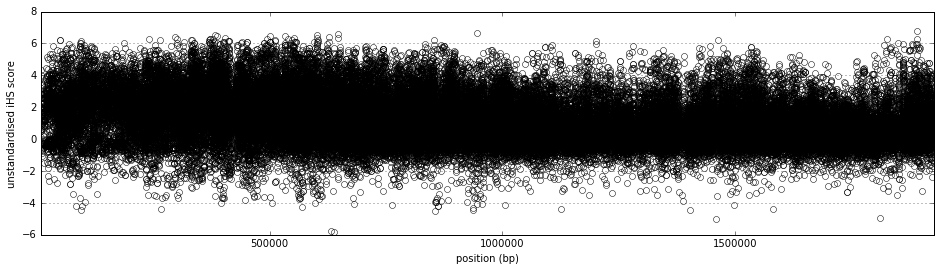

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised iHS score')
plt.autoscale(axis='x', tight=True);

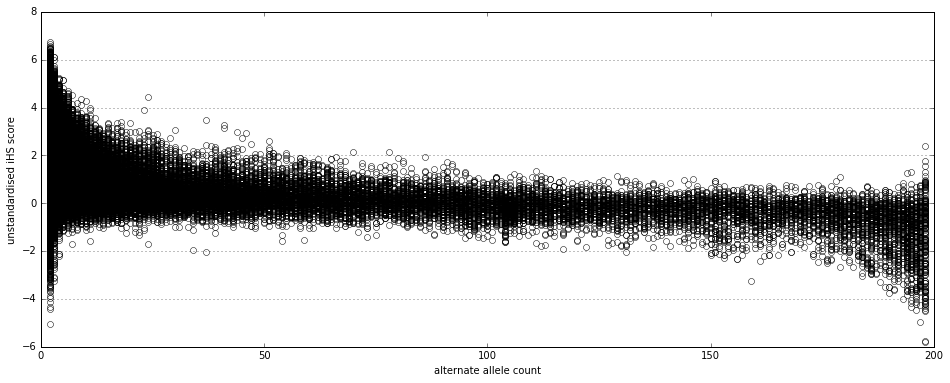

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised iHS score')
plt.grid(axis='y');

In [17]:
import scipy as sp
import scipy.stats

In [18]:
bins = np.arange(h.n_haplotypes+2)
mean_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='mean', bins=bins)
std_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='std', bins=bins)

In [19]:
bins.shape

(202,)

In [20]:
mean_ihs_by_aac.shape, std_ihs_by_aac.shape

((201,), (201,))

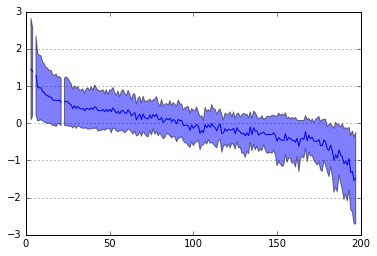

In [21]:
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac - std_ihs_by_aac, 
                 mean_ihs_by_aac + std_ihs_by_aac,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac)
plt.grid(axis='y');

In [22]:
score_centred = np.empty_like(score)
score_normed = np.empty_like(score)

for aac in bins[:-1]:
    loc = ac_seg[:, 1] == aac
    score_centred[loc] = (score[loc] - mean_ihs_by_aac[aac]) 
    score_normed[loc] =  score_centred[loc] / std_ihs_by_aac[aac]

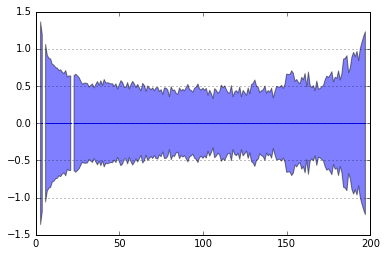

In [23]:
mean_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='mean', bins=bins)
std_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_centred - std_ihs_by_aac_centred, 
                 mean_ihs_by_aac_centred + std_ihs_by_aac_centred,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_centred)
plt.grid(axis='y');

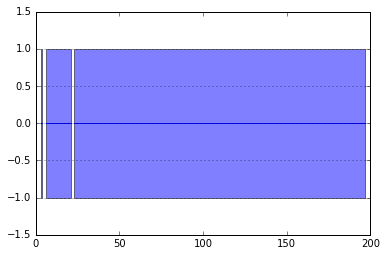

In [24]:
mean_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='mean', bins=bins)
std_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_normed - std_ihs_by_aac_normed, 
                 mean_ihs_by_aac_normed + std_ihs_by_aac_normed,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_normed)
plt.grid(axis='y');

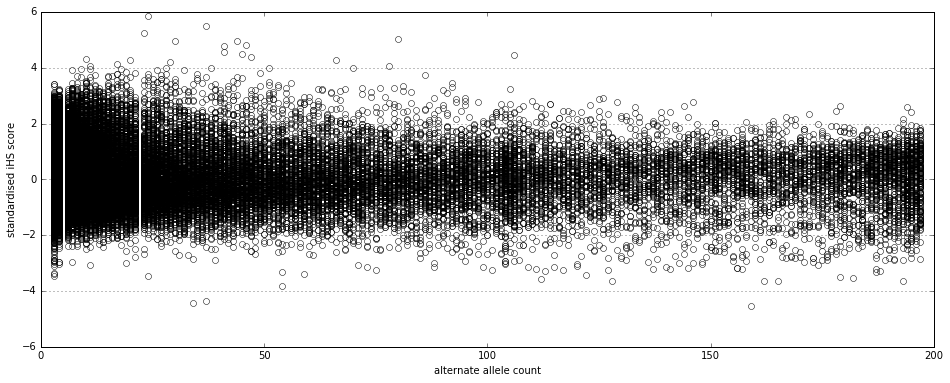

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score_normed, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('standardised iHS score')
plt.grid(axis='y');

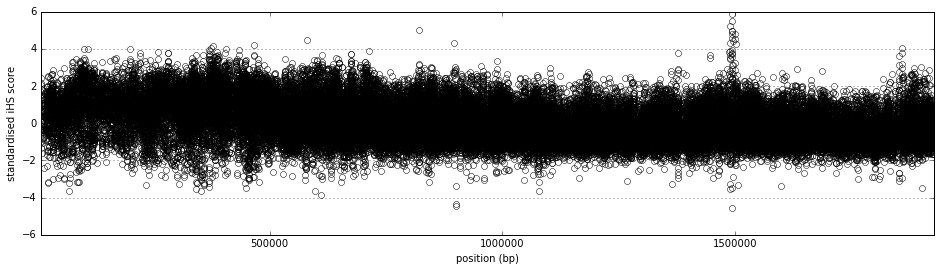

In [26]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardised iHS score')
plt.autoscale(axis='x', tight=True);

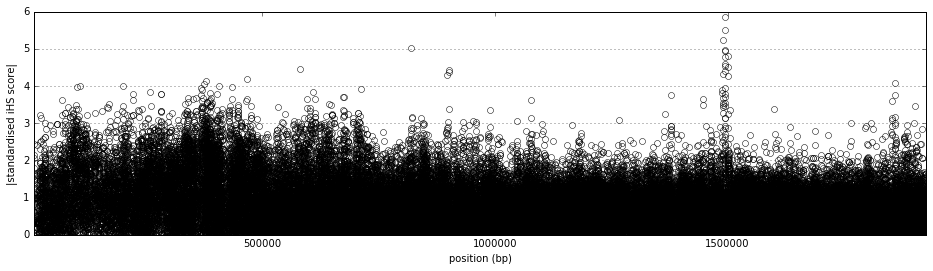

In [27]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, np.abs(score_normed), linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('|standardised iHS score|')
plt.autoscale(axis='x', tight=True);

In [28]:
h_seg.shape

(106315, 200)

In [29]:
cProfile.run('allel.stats.ihs(h_seg[:50000], pos_seg[:50000], min_ehh=0.05, include_edges=True, use_threads=False)', sort='time')

         118 function calls in 6.958 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    6.956    3.478    6.956    3.478 stats.pyx:700(ihh01_scan_int8)
        1    0.002    0.002    6.958    6.958 selection.py:371(ihs)
        7    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    6.958    6.958 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 ndarray.py:1810(__getitem__)
       18    0.000    0.000    0.000    0.000 stringsource:341(__cinit__)
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        1    0.000    0.000    6.958    6.958 <string>:1(<module>)
        2    0.000    0.000    6.956    3.478 {allel.opt.stats.ihh01_scan_int8}
        6    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
       14    0.000    0.000    0.000    0.000 stringsource:643(memoryview_cwrapper)
  

In [30]:
# import line_profiler

# # lprun = line_profiler.LineProfiler(allel.opt.stats.ssl01_scan_int8, allel.opt.stats.ssl2ihh)
# lprun = line_profiler.LineProfiler(allel.opt.stats.ssl01_scan_int8)
# lprun.run('allel.stats.ihs(h_seg[:1000], pos_seg[:1000], min_ehh=0, include_edges=True)')
# lprun.print_stats()

## Gap handling

In [90]:
loc_variants = slice(7000000, 8000000, 1)
n_samples = 50

h = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [91]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([30809711, 30809712, 30809713, ..., 36036863, 36036865, 36036866], dtype=int32)

In [92]:
ac = h.count_alleles(max_allele=1)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 10)
h_seg = h.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

41474

In [93]:
def plot_score_gap(score, pos, ylim=(-7, 7)):

    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(111)
    ax.plot(pos, score, linestyle=' ', marker='o', mfc='none')
    ax.grid(axis='y')
    ax.set_xlabel('position (bp)')
    ax.set_ylabel('score')
    ax.set_ylim(*ylim)

    ax = ax.twinx()
    x = (pos[:-1] + pos[1:]) / 2
    y = np.diff(pos)
    ax.plot(x, y)
    ax.set_ylabel('gap size (bp)')
    ax.autoscale(axis='x', tight=True);

In [94]:
score_unadjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1)

In [95]:
score_gap_adjusted = allel.stats.ihs(h_seg, pos_seg, min_ehh=0.05, max_gap=200000, clip_gap=100)

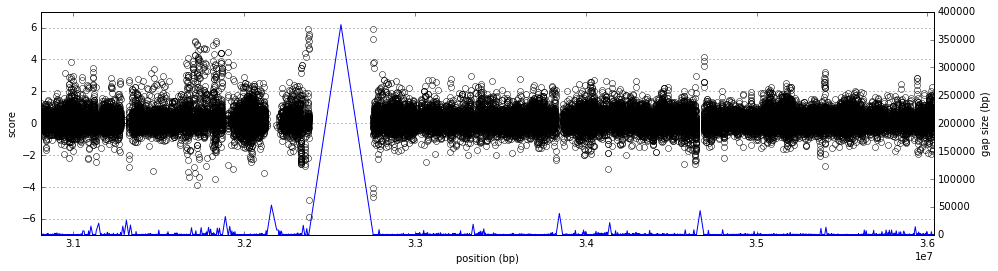

In [96]:
plot_score_gap(score_unadjusted, pos_seg)

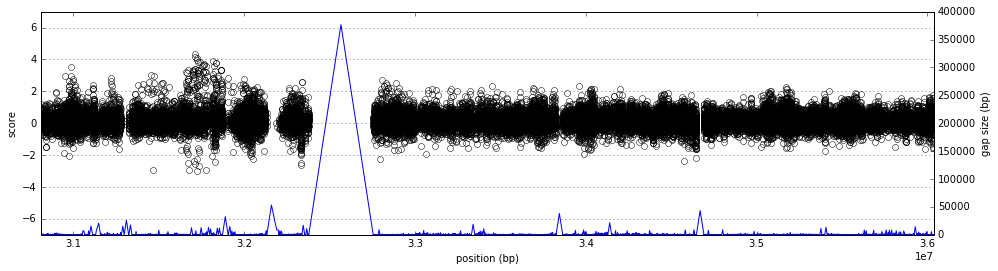

In [97]:
plot_score_gap(score_gap_adjusted, pos_seg)

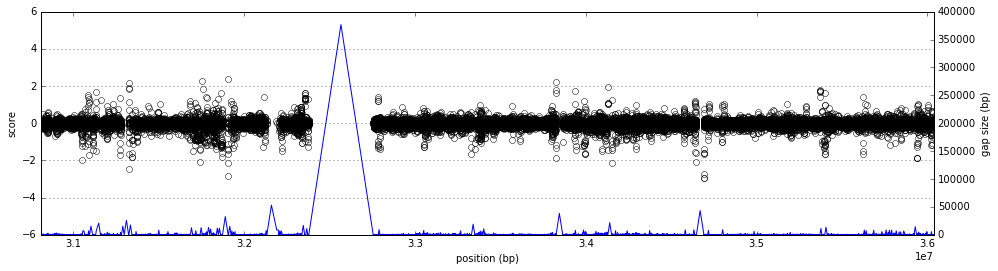

In [98]:
plot_score_gap(score_gap_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

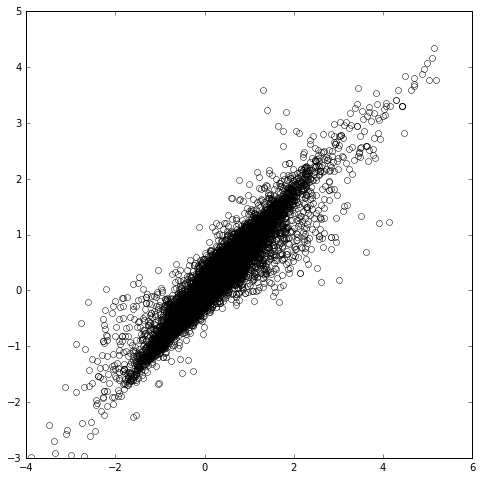

In [99]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_gap_adjusted, marker='o', mfc='none', linestyle=' ');